In [1]:
import os
import gc

import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD101T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

In [2]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')
des_drug[isnan(des_drug)] = 0
des_drug[des_drug > 1E10] = 1E10
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

In [6]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length_target = 1000
max_length_drug = 150
pad_target = pad_sequences(encode_target, maxlen=max_length_target, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length_drug, padding='post', truncating='post')

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [12]:
# Define architecture
def get_model():
    input_target, att_out_target = arch_obj.protSeq(max_length_target)
    input_drug, att_out_drug = arch_obj.drugSeq(max_length_drug)
    input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

    concat = Concatenate()([att_out_target,att_out_drug, dense_drug_des_2])

    dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
    #dense_1_dropout = Dropout(0.1)(dense_1)
    dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
    #dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)
    dense_2_dropout = Dropout(0.4)(dense_2)

    x_output = Dense(3, activation='softmax')(dense_2_dropout)

    # Bulid and compile model
    model = Model(inputs=[input_target, input_drug, input_drug_des], outputs=x_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#model1.summary()

In [13]:
np.max(des_drug)

10000000000.0

In [15]:
# Initialize results dicts
CV = [0,1,2,3,4]
results_CV = {key: None for key in CV}

# Training
CV = 5
for i in range(CV):
    # device = cuda.get_current_device()
    # device.reset()

    # Scale drug descriptors
    scaler = MinMaxScaler()
    scaled_des_drug = scaler.fit_transform(des_drug)

    # Split indics into train/test
    from sklearn.model_selection import train_test_split
    indices = list(range(len(DTI_index)))
    train_target, test_target, train_drug, test_drug, train_des, test_des, y_train, y_test = train_test_split(pad_target, pad_drug, scaled_des_drug, y, test_size=0.2, random_state=i)

    # Early Stopping & checkpoint
    model = get_model()
    es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
    filepath='checkpoints/'+EXP+'/'+EXP+'_cp_'+str(i)+'.hdf5'
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, epsilon=1e-4, mode='min')

    history = model.fit(
        [train_target, train_drug, train_des], y_train,
        epochs=500, batch_size=256,
        validation_split=0.2,
        callbacks=[es, model_checkpoint]
        )

    # Load saved model
    saved_model = load_model('checkpoints/'+EXP+'/'+EXP+'_cp_'+str(i)+'.hdf5',custom_objects={'attention': architecture.attention()})

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    res = saved_model.evaluate([test_target, test_drug, test_des], y_test, batch_size=256)
    print("test loss, test acc:", res)

    # Calculate ROC and PR characteristics
    roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug, c = test_des)
    precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug, c = test_des)
    prediction = saved_model.predict([test_target, test_drug, test_des])
    f1 = f1_score(np.argmax(y_test,axis=1), np.argmax(prediction,axis=1), average='macro')

    keys = ['val_loss','val_accuracy','roc_auc','fpr','tpr','f1_score', 'precision','recall','average_precision']
    results = {key: None for key in keys}

    results['val_loss'] = res[0]
    results['val_accuracy'] = res[1]
    results['roc_auc'] = roc_auc
    results['fpr'] = fpr
    results['tpr'] = tpr
    results['f1_score'] = f1
    results['precision'] = precision
    results['recall'] = recall
    results['average_precision'] = average_precision
    results_CV[i] = results
    
    del model
    del saved_model

===========>.] - ETA: 0s - loss: 0.4690 - accuracy: 0.8060
Epoch 00017: val_loss did not improve from 0.59343
155/155 [==============================] - 19s 123ms/step - loss: 0.4691 - accuracy: 0.8060 - val_loss: 0.6037 - val_accuracy: 0.7467
Epoch 18/500
154/155 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8125
Epoch 00018: val_loss improved from 0.59343 to 0.59278, saving model to checkpoints/CD101T10/CD101T10_cp_3.hdf5
155/155 [==============================] - 19s 122ms/step - loss: 0.4537 - accuracy: 0.8125 - val_loss: 0.5928 - val_accuracy: 0.7558
Epoch 19/500
154/155 [============================>.] - ETA: 0s - loss: 0.4408 - accuracy: 0.8186
Epoch 00019: val_loss did not improve from 0.59278
155/155 [==============================] - 19s 122ms/step - loss: 0.4408 - accuracy: 0.8186 - val_loss: 0.6056 - val_accuracy: 0.7555
Epoch 20/500
154/155 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8215
Epoch 00020: val_loss did not i

In [16]:
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [18]:
save_obj(results_CV, EXP)

In [30]:
# EXTERNAL VALIDATION
davis_anas_DTI = pd.read_csv('val_data/davis_anas_DTI.csv')
davis_anas_targets = os.listdir('val_data/fasta_davis_anas')  # List all target fasta files
davis_anas_drug_smiles = pd.read_csv('val_data/davis_anas_smiles.csv')
davis_anas_drug_des = pd.read_csv('val_data/fset_drugs_davis_anas.csv')
davis_anas_drug_des = davis_anas_drug_des.loc[:, davis_anas_drug_des.columns != 'Unnamed: 0']

# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target','seq'])
    for fasta in tqdm(targets):
        f = open('val_data/fasta_davis_anas/'+fasta,'r')
        lines = "".join(line.strip() for line in f.readlines()[1:])
        dict = {'target':fasta.split('.')[0], 'seq':lines}
    
        target_seq = target_seq.append(dict, True)
        f.close()
    return target_seq

davis_anas_target_seq = fetchFasta(davis_anas_targets)

100%|██████████| 237/237 [00:00<00:00, 746.97it/s]


In [31]:
eval_P = pd.DataFrame()
for target in davis_anas_DTI['protein_id']:
    dic = davis_anas_target_seq[davis_anas_target_seq['target']==target]
    eval_P = eval_P.append(dic)

eval_T = pd.DataFrame()
for drug in davis_anas_DTI['compound_id']:
    dic = davis_anas_drug_smiles[davis_anas_drug_smiles['drug']==drug][['drug', 'seq']]
    eval_T = eval_T.append(dic)

eval_D = pd.DataFrame()
for drug in davis_anas_DTI['compound_id']:
    des = davis_anas_drug_des[davis_anas_drug_des['Drug']==drug]
    dic = des.loc[:,des.columns!='Drug']
    eval_D = eval_D.append(dic)

# label/integer encoding output variable: (y)
davis_anas_le = LabelEncoder()
davis_anas_y = davis_anas_le.fit_transform(davis_anas_DTI['activity'].tolist())
# One hot encoding of outputs
davis_anas_y = to_categorical(davis_anas_y)

In [32]:
davis_anas_codes_drug = [char for char in ''.join(set(''.join(davis_anas_drug_smiles['seq'].values)))]
davis_anas_char_dict_drug = obj.create_dict(davis_anas_codes_drug)

davis_anas_encode_target = obj.integer_encoding(eval_P, char_dict_target) 
davis_anas_encode_drug = obj.integer_encoding(eval_T, davis_anas_char_dict_drug) 

# padding sequences
max_length_target = 1000
max_length_drug = 150
davis_anas_pad_target = pad_sequences(davis_anas_encode_target, maxlen=max_length_target, padding='post', truncating='post')
davis_anas_pad_drug = pad_sequences(davis_anas_encode_drug, maxlen=max_length_drug, padding='post', truncating='post')

davis_anas_pad_target.shape, davis_anas_pad_drug.shape, eval_D.shape, davis_anas_y.shape

((4255, 1000), (4255, 150), (4255, 111), (4255, 3))

In [35]:
# Load saved model
saved_model = load_model('checkpoints/'+EXP+'/'+EXP+'_cp_0.hdf5', custom_objects={'attention': architecture.attention()})
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([davis_anas_pad_target, davis_anas_pad_drug, eval_D.values], davis_anas_y, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
17/17 [==============================] - 1s 49ms/step - loss: 68146096.0000 - accuracy: 0.7593
test loss, test acc: [68146096.0, 0.7593419551849365]


In [37]:
from sklearn.metrics import classification_report
import numpy as np
prediction = saved_model.predict([davis_anas_pad_target, davis_anas_pad_drug, eval_D.values])
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(np.argmax(davis_anas_y,axis=1), np.argmax(prediction,axis=1), target_names=target_names))

precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       233
     class 1       0.76      1.00      0.86      3231
     class 2       0.00      0.00      0.00       791

    accuracy                           0.76      4255
   macro avg       0.25      0.33      0.29      4255
weighted avg       0.58      0.76      0.66      4255



In [28]:
from sklearn.metrics import f1_score
prediction = saved_model.predict([davis_metz_pad_target,davis_metz_pad_drug,eval_D.values])
f1_score(np.argmax(davis_metz_y,axis=1), np.argmax(prediction,axis=1), average='micro')

0.7021359223300971

In [21]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug, c = eval_D.values)
precision, recall, average_precision = obj.aupr(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug, c = eval_D.values)

In [26]:
average_precision

{0: 0.1144743775878513,
 1: 0.7207673861848944,
 2: 0.2769163773225609,
 'micro': 0.6610073130431412}

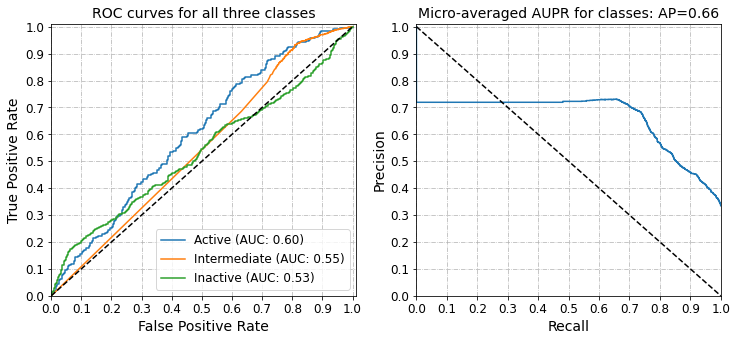

In [23]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision,validation=True, save=True)